In [1]:
import numpy as np
from jax import jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
from glob import glob
import math

In [65]:
date = '20240516'
files = os.listdir(f'./data/{date}')

save_files = []
config_files = []
counter = 0
for file in files:
    path = f'./data/{date}/{file}/' 
    files_to_maybe_load = glob(path + 'params_*_*.npy')
    min_loss = np.inf
    for file in files_to_maybe_load:
        position_ = file.rfind('_')
        position_stop = file.rfind('.')
        loss = float(file[position_+1:position_stop])
        if loss < min_loss:
            file_to_load = file
            min_loss = loss
    
    config = np.load(path + 'config_dict.npy', allow_pickle=True)[()]
    if config['num_stim'] == 6:
        print(f'{counter}: {file_to_load}')
        print(config['mu_W'], config['repeat'])
        counter += 1
        
        save_files.append(file_to_load)
        config_files.append(path + 'config_dict.npy')

0: ./data/20240516/13:13:38_9953/params_501737_163.72328.npy
0.1 1
1: ./data/20240516/13:13:38_7362/params_517793_160.30731.npy
0.1 1
2: ./data/20240516/13:13:38_8096/params_300357_177.77548.npy
0.1 1
3: ./data/20240516/13:13:38_8513/params_200039_194.20795.npy
0.1 1
4: ./data/20240516/13:13:38_7011/params_201214_195.13603.npy
0.1 1
5: ./data/20240516/13:13:42_7564/params_350942_155.39783.npy
0.1 0
6: ./data/20240516/13:17:01_439/params_150687_193.99013.npy
0.1 0
7: ./data/20240516/13:17:31_1291/params_100183_217.07379.npy
0.1 0
8: ./data/20240516/13:17:31_9106/params_100193_251.52661.npy
0.1 0
9: ./data/20240516/13:17:31_4121/params_151668_199.86247.npy
0.1 0


In [66]:
num = 1

params = np.load(save_files[num], allow_pickle=True)[()]
config = np.load(config_files[num], allow_pickle=True)[()]

In [20]:
params = np.load('./best_data_fitting_params_extreme_params.npy', allow_pickle = True)[()]
config = np.load('./data/20240512/13:06:58_449994/config_dict.npy', allow_pickle = True)[()]
config['goal_encoding'] = 2
config['N'] = 35

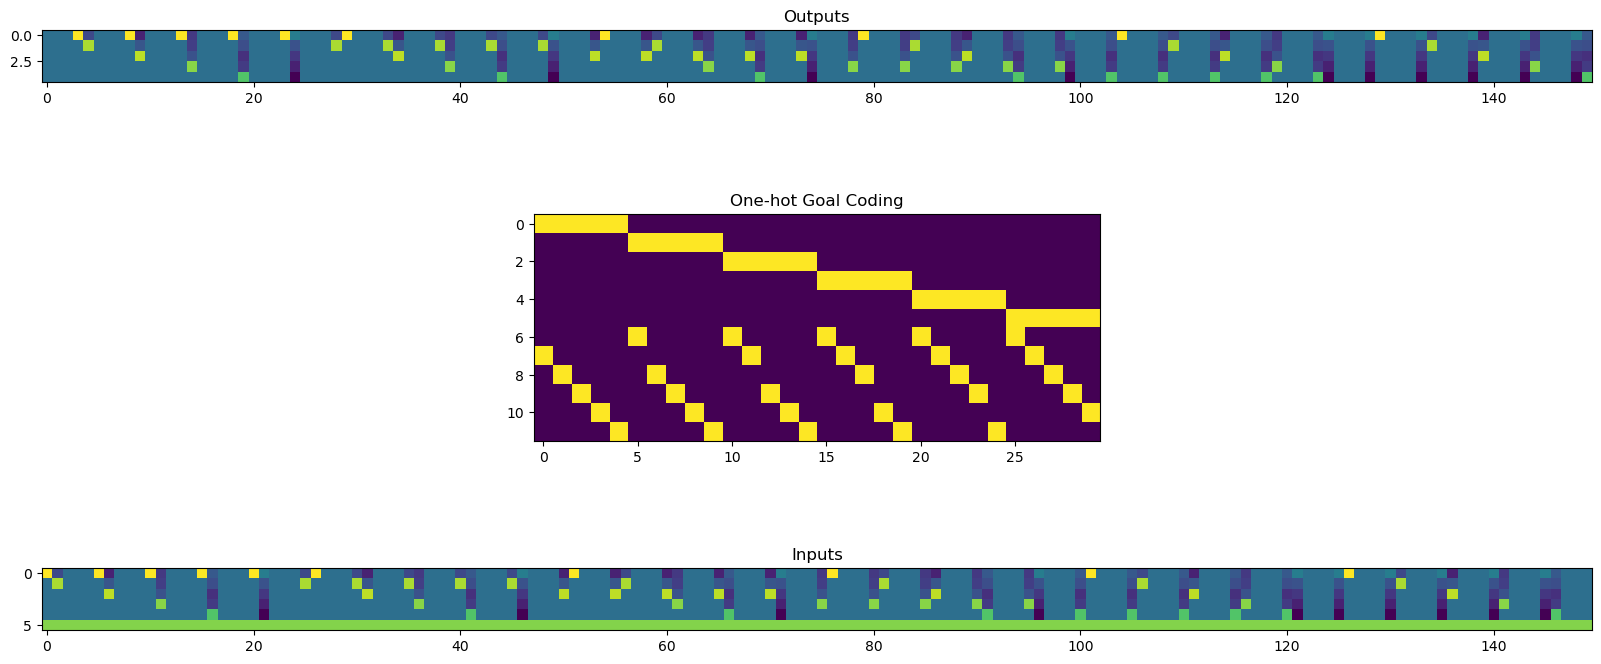

In [21]:
# Couple of functions, one to extract top (2) PCs, one to generate sequences
# At the bottom of the cell we programme in the sequence parameters (how many stimuli, do we include repeats, etc.)
# Then you generate the required inputs and output
    
def get_2_PCs(vecs, num_eigs = 2):
    vecs = vecs - np.mean(vecs, axis = 1)[:,None]
    covar = vecs@vecs.T
    eigvals, eigvecs = np.linalg.eig(covar)
    
    ordering = np.argsort(eigvals)[::-1]
    #print(f"Propotion of Activity Kept: {np.sum(eigvals[ordering[:2]])/np.sum(eigvals)}")
    return np.real(eigvecs[:,ordering[:num_eigs]])

def dot_plot(g_encodings):
    dots = np.zeros([num_stim])
    for q in range(num_stim):
        dots[q] = g_encodings[:,q,0].T@g_encodings[:,q,1]
    plt.figure()
    plt.hist(dots, 6)
    plt.title('Dot Products')
    plt.xlabel('Dot Product')
    plt.ylabel('Count')

def generate_sequences(generators, seq_len, repeat, debias_outputs, debias_inputs):

    if seq_len > 4:
        print("SEQUENCES LONGER THAN 4 NOT IMPLEMENTED")

    num_stim, slot_dim = generators.shape
        
    task_len = 2*seq_len + 1
    
    if repeat == 0:
        num_tasks = int(math.factorial(num_stim)/(math.factorial(num_stim-seq_len)))
    else:
        num_tasks = num_stim**seq_len
    num_states = num_tasks*task_len
    
    outputs = np.zeros([slot_dim, num_states])
    inputs = np.zeros([slot_dim, num_states])
    regression_targets = np.zeros([num_stim*seq_len, num_tasks])

    # Must be a smarter way than this dumbness...
    if seq_len == 1:
        counter = 0
        task_counter = 0
        for q in range(num_states):
            inputs[:, counter] = generators[q,:]
            counter += 1
    
            counter += 1
            outputs[:, counter] = generators[q,:]
            counter += 1
    
            regression_targets[q, task_counter] = 1
            task_counter += 1
    
    if seq_len == 2:
        counter = 0
        task_counter = 0
        for q in range(num_stim):
            for q_p in range(num_stim):
                if repeat==0 and q_p == q:
                    continue
                inputs[:, counter] = generators[q,:]
                counter += 1
                inputs[:, counter] = generators[q_p,:]
                counter += 1
    
                counter += 1
                
                outputs[:, counter] = generators[q,:]
                counter += 1
                outputs[:, counter] = generators[q_p,:]
                counter += 1
    
                regression_targets[q, task_counter] = 1
                regression_targets[q_p+num_stim, task_counter] =  1
                task_counter += 1
                
    if seq_len == 3:
        counter = 0
        task_counter = 0
        for q in range(num_stim):
            for q_p in range(num_stim):
                for q_pp in range(num_stim):
                    if repeat==0:
                        if q == q_p or q_p == q_pp or q == q_pp:
                            continue
                    inputs[:, counter] = generators[q,:]
                    counter += 1
                    inputs[:, counter] = generators[q_p,:]
                    counter += 1
                    inputs[:, counter] = generators[q_pp,:]
                    counter += 1
    
                    counter += 1
    
                    outputs[:, counter] = generators[q,:]
                    counter += 1
                    outputs[:, counter] = generators[q_p,:]
                    counter += 1
                    outputs[:, counter] = generators[q_pp,:]
                    counter += 1
    
                    regression_targets[q, task_counter] = 1
                    regression_targets[q_p+num_stim, task_counter] =  1
                    regression_targets[q_pp+2*num_stim, task_counter] =  1
                    task_counter += 1
                    
    if seq_len == 4:
        counter = 0
        task_counter = 0
        for q in range(num_stim):
            for q_p in range(num_stim):
                for q_pp in range(num_stim):
                    for q_ppp in range(num_stim):
                        if repeat==0:
                            if q == q_p or q_p == q_pp or q == q_pp or q == q_ppp or q_p == q_ppp or q_pp == q_ppp:
                                continue
                        inputs[:, counter] = generators[q,:]
                        counter += 1
                        inputs[:, counter] = generators[q_p,:]
                        counter += 1
                        inputs[:, counter] = generators[q_pp,:]
                        counter += 1
                        inputs[:, counter] = generators[q_ppp,:]
                        counter += 1
                        
                        counter += 1
        
                        outputs[:, counter] = generators[q,:]
                        counter += 1
                        outputs[:, counter] = generators[q_p,:]
                        counter += 1
                        outputs[:, counter] = generators[q_pp,:]
                        counter += 1
                        outputs[:, counter] = generators[q_ppp,:]
                        counter += 1
                            
                        regression_targets[q, task_counter] = 1
                        regression_targets[q_p+num_stim, task_counter] =  1
                        regression_targets[q_pp+2*num_stim, task_counter] =  1
                        regression_targets[q_ppp+3*num_stim, task_counter] =  1
                        task_counter += 1
    
    if debias_outputs == 1:
        if np.sum(np.abs(np.mean(outputs, axis = 1)) > 0.0001):
            print('DEBIASING OUTPUTS')
            outputs = outputs - np.mean(outputs, axis = 1)[:,None]
    elif debias_outputs != 0:
        print('SHIFTING OUTPUTS')
        outputs = outputs - debias
    
    if debias_inputs == 1:
        if np.sum(np.abs(np.mean(inputs, axis = 1)) > 0.0001):
            print('DEBIASING INPUTS')
            inputs = inputs - np.mean(inputs, axis = 1)[:,None]
    elif debias_inputs != 0:
        print('SHIFTING INPUTS')
        inputs = inputs - debias
    
    inputs = np.vstack([inputs, np.ones([1, num_states])/np.sqrt(2)])
    
    plt.figure(figsize = (20,10))
    plt.subplot(3,1,1)
    plt.title('Outputs')
    plt.imshow(outputs)
    plt.subplot(3,1,2)
    plt.imshow(regression_targets)
    plt.title('One-hot Goal Coding')
    plt.subplot(3,1,3)
    plt.imshow(inputs)
    plt.title('Inputs')

    return inputs, outputs, regression_targets, num_states, task_len

num_stim = config['num_stim'] # Number of Stimuli
seq_len = 2 # Seq length
repeat = config['repeat'] # Do you want to include repeats?
debias_outputs = config['debias_outputs'] # Do you want to debias the outputs? Leave this at 
debias_inputs = config['debias_inputs'] # Do you want to debias the inputs?
goal_encoding = config['goal_encoding'] # 0 for 1-hot, 1 for sine and cosine, 2 for loaded from data old, 3 for new from data, 4 for exact from data

if goal_encoding == 0:
    generators = np.eye(num_stim)
elif goal_encoding == 1:
    thetas = [2*np.pi/num_stim*i for i in range(num_stim)]
    generators = np.stack([np.cos(thetas), np.sin(thetas)]).T
elif goal_encoding == 2:
    generators = np.load('./best_fitting_symmetric_generators.npy')
    num_stim = generators.shape[0]
data_dim = generators.shape[1]


if generators.shape[0] != num_stim:
    print("NOT CORRECT num_stim!!!")

 
inputs, outputs, regression_targets, D, task_len = generate_sequences(generators, seq_len, repeat, debias_outputs, debias_inputs)

In [22]:
config

{'repeat': 0,
 'reward': 1,
 'num_stim': 3,
 'save_iter': 10000,
 'T': 100000000,
 'learning_rate': 1e-05,
 'random_seed': 449994,
 'N': 35,
 'mu_fit': 10000,
 'mu_G': 10,
 'mu_W': 0.1,
 'mu_R': 0.1,
 'mu_pos': 2000,
 'fit_thresh': 0.01,
 'debias_outputs': 1,
 'debias_inputs': 1,
 'goal_encoding': 2}

In [23]:
N = config['N']

def generate_rep(params, inputs):
    g = jnp.zeros([N, D])
    g = g.at[:,::task_len].set(params["I"]@inputs[:,::task_len])
    for t in range(1,task_len):
        g = g.at[:,t::task_len].set(params["I"]@inputs[:,t::task_len] + params["W"]@g[:,t-1::task_len])

    g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
    return g_bias   

g = generate_rep(params, inputs)

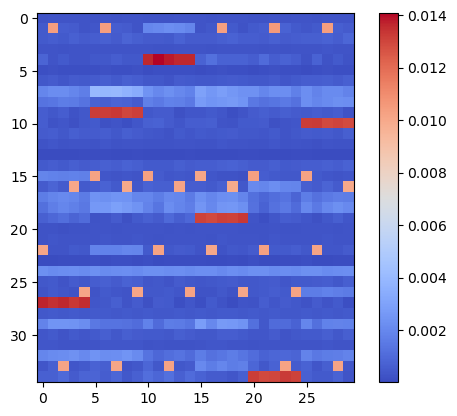

In [24]:
g_delay = g[:-1,2::task_len]
plt.imshow(g_delay, cmap = 'coolwarm')
plt.colorbar()

Subspace Angles: [[83.09898696 83.74003373]]
83.41951034390367


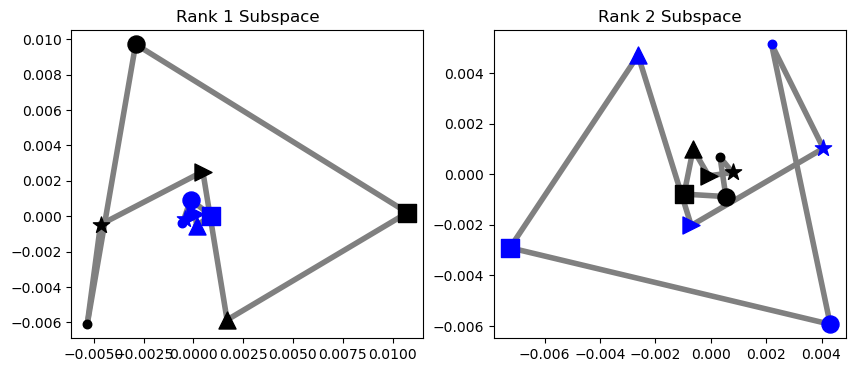

In [27]:
def difference_analysis(g_analysis, reg_tar, seq_len, num_stim, num_eigs = 2, fig = True):
    N = g_analysis.shape[0]
    
    # Now try our new extraction scheme. Get difference vectors for all pairs of points
    difference_vectors = np.zeros([N, num_stim, num_stim, seq_len])
    for q in range(num_stim):
        for qp in range(num_stim):
            for r in range(seq_len):
                q_in_r = reg_tar[r*num_stim + q,:] == 1
                qp_in_r = reg_tar[r*num_stim + qp,:] == 1
                q_not_in_others = np.all((reg_tar[np.delete(np.arange(q, seq_len*num_stim, num_stim), r),:] == 0), axis = 0)
                qp_not_in_others = np.all((reg_tar[np.delete(np.arange(qp, seq_len*num_stim, num_stim), r),:] == 0), axis = 0)
                averaging_indices_q = np.all(np.vstack([q_in_r, qp_not_in_others, q_not_in_others]), axis = 0)
                averaging_indices_qp = np.all(np.vstack([qp_in_r, qp_not_in_others, q_not_in_others]), axis = 0)
    
                difference_vectors[:,q,qp,r] = np.mean(g_analysis[:, averaging_indices_q], axis = 1) - np.mean(g_analysis[:, averaging_indices_qp], axis = 1)
        
    # Now extract a couple of PCs and calculate the angles between them?
    PCs = np.zeros([N, num_eigs, seq_len])
    for r in range(seq_len):
        difference_vectors_flat = np.zeros([N, int(num_stim*(num_stim-1)/2)])
        counter = 0
        for q in range(num_stim):
            for qp in range(q):
                difference_vectors_flat[:,counter] = difference_vectors[:,q,qp,r]
                counter += 1
        PCs[:,:,r] = get_2_PCs(difference_vectors_flat, num_eigs = num_eigs)
    
    # Let's get the subspace angles
    subspace_angles = np.zeros([int((seq_len-1)*seq_len/2), num_eigs])
    counter = 0
    for r in range(seq_len):
        for r_p in range(r):
            dot_prod = PCs[:,:,r].T@PCs[:,:,r_p]
            U, S, V = np.linalg.svd(dot_prod)
            try:
                subspace_angles[counter, :] = np.arccos(S)/np.pi*180
            except:
                subspace_angles[counter,:] = S
            counter += 1

    # Finally, let's reconstruct the activity from these difference vectors
    g_encodings = np.zeros([N, num_stim, seq_len])
    projections = np.zeros([num_eigs, num_stim, seq_len, seq_len])
    for seq_ind in range(seq_len):
        g_encodings[:,:,seq_ind] = difference_vectors[:,0,:,seq_ind] - np.mean(difference_vectors[:,0,:,seq_ind],axis = 1)[:,None]

    for seq_ind in range(seq_len):
        for seq_indp in range(seq_len):
            projections[:,:,seq_ind, seq_indp] = PCs[:,:,seq_ind].T@g_encodings[:,:,seq_indp]

    if fig:
        markers = ['.','o','s','^','>','*']
        colours = ['k', 'b', 'r']
    
        if num_eigs%2 == 0:
            plot_3D = 0
        else:
            plot_3D = 1
        plot_rows = int(np.floor(num_eigs/2))
        
        fig = plt.figure(figsize = (10,4*plot_rows))
        for r in range(seq_len):
            for plot in range(plot_rows):
                if plot == plot_rows - 1 and plot_3D:
                    num = plot_rows*100 + seq_len*10 + r+1+plot*seq_len
                    ax = fig.add_subplot(num, projection='3d')
                    if plot == 0:
                        plt.title(f'Rank {r+1} Subspace')
    
                    for rp in range(seq_len):
                        for q in range(num_stim):
                            ax.scatter(projections[0+2*plot,q,r,rp], projections[1+2*plot,q,r,rp], projections[2+2*plot,q,r,rp], s = 150, zorder=1, color = colours[rp], marker = markers[q])
                            ax.plot([projections[0+2*plot,q,r,rp], projections[0+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[1+2*plot,q,r,rp], projections[1+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[2+2*plot,q,r,rp], projections[2+2*plot,np.mod(q+1,num_stim),r,rp]], c='gray', lw = 4,zorder=0)
    
                else:
                    plt.subplot(plot_rows,seq_len,r+1+plot*seq_len)
                    if plot == 0:
                        plt.title(f'Rank {r+1} Subspace')
    
                    for rp in range(seq_len):
                        for q in range(num_stim):
                            plt.plot([projections[0+2*plot,q,r,rp], projections[0+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[1+2*plot,q,r,rp], projections[1+2*plot,np.mod(q+1,num_stim),r,rp]], c='gray', lw = 4,zorder=0)
                            plt.scatter(projections[0+2*plot,q,r,rp], projections[1+2*plot,q,r,rp], s = 150, zorder=1, color = colours[rp], marker = markers[q])

        print(f'Subspace Angles: {subspace_angles}')
    return subspace_angles, difference_vectors, g_encodings, projections

subspace_angles, difference_vectors, g_encodings, projections = difference_analysis(g_delay, regression_targets, seq_len, num_stim, num_eigs = 2)
print(np.mean(subspace_angles))

Best Fitting Scale Parameters: 0.0806751013556964


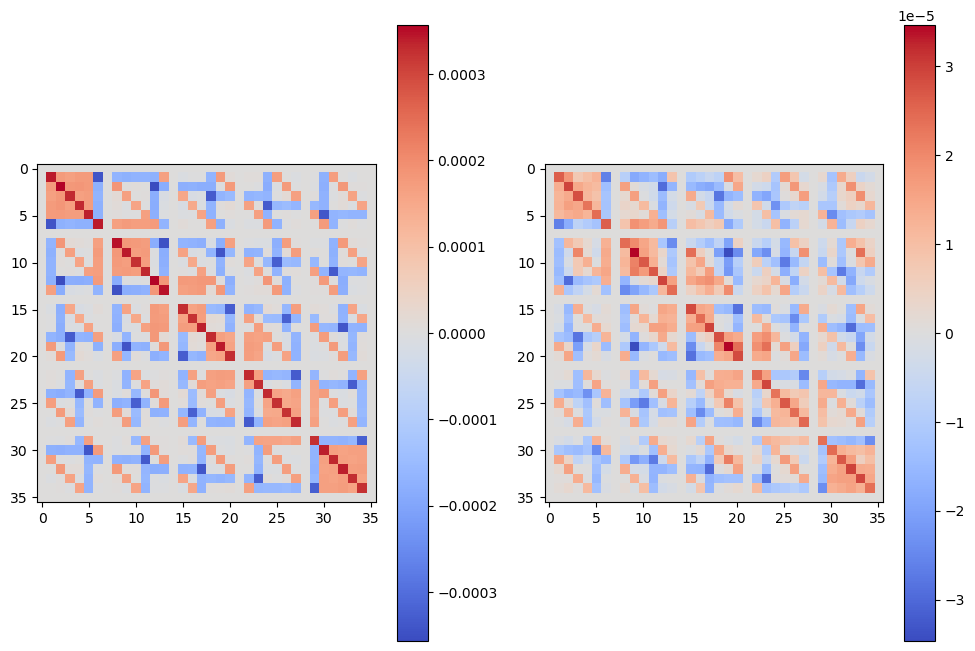

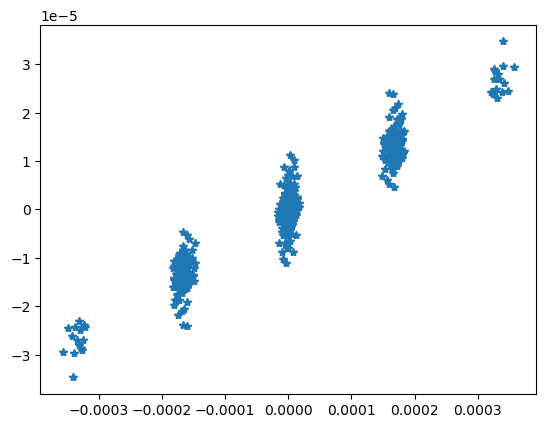

In [26]:

self_dot_mat = np.zeros([36, 36])
across_dot_mat = np.zeros([36, 36])
for theta1 in range(6):
    for theta2 in range(6):
        for theta1p in range(6):
            for theta2p in range(6):
                self_dot_mat[theta1*6 + theta2, theta1p*6 + theta2p] = difference_vectors[:,theta1, theta2, 0].T@difference_vectors[:,theta1p, theta2p, 0]
                across_dot_mat[theta1*6 + theta2, theta1p*6 + theta2p] = difference_vectors[:,theta1, theta2, 1].T@difference_vectors[:,theta1p, theta2p, 0]
plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(self_dot_mat,cmap='coolwarm')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(across_dot_mat,cmap='coolwarm')
plt.colorbar()

best_fitting_scale_parameter = np.sum(np.multiply(across_dot_mat, self_dot_mat))/np.sum(np.power(self_dot_mat, 2))
print(f'Best Fitting Scale Parameters: {best_fitting_scale_parameter}')

plt.figure()
plt.plot(np.ndarray.flatten(self_dot_mat), np.ndarray.flatten(across_dot_mat), '*')


In [34]:
1754.7188/0.19197893

9140.163454395752

In [29]:
@jit
def loss_R(R):
    R_sub = R[:-1,:]
    return jnp.sum(jnp.power(R_sub, 2))

@jit
def loss_act(g):
    return jnp.sum(jnp.power(g[:-1,:], 2))

@jit
def generate_R(g, outputs):
    mat0 = jnp.matmul(g, g.T)
    mat1 = jnp.matmul(g, outputs.T)
    mat2 = jnp.matmul(jnp.linalg.inv(mat0 + 0.0001*jnp.eye(N+1)), mat1)
    return mat2

R = generate_R(g, outputs)
print(loss_R(R))
print(loss_act(g))

1754.7188
0.19197893


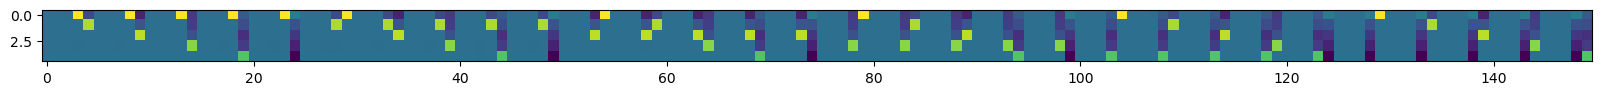

In [33]:
plt.figure(figsize = (20, 4))
plt.imshow(R.T@g)